# 🔐 Authentication

## 📚 Loading libraries

In [2]:
from imblearn.under_sampling import RandomUnderSampler
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shap
import sys
import time
import tsfresh

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from utils.const import *
from utils.helperFunctions import *

import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

## 📍 Variables

In [3]:
# Listing IDs
ids = ['id1', 'id2', 'id3']
# Choose what ID to process
id = 'id2'
ids_remove = [x for x in ids if x != id]

# Filter features and keep only relevant ones
filterFeatures = True

# Undersampling
fairUndersampling = False       # Each class same number
targetedUndersampling = True    # Downsample most frequent class
customBalance = False           # Downsample by specifying number of samples for each label

# If True, perform authentication. If False, perform identification
# - Authentication: binary classification
# - Identificatiom: multiclass classification
authentication = False

# Results names and folders
if not os.path.exists(RESULTS):
    os.mkdir(RESULTS)
    os.mkdir(FIGURES)

if authentication:
    saveBase = id.upper() + '_AUTH'
else:
    saveBase = id.upper() + '_IDENT'

imageFolder = os.path.join(FIGURES, saveBase)
if not os.path.exists(imageFolder):
    os.mkdir(imageFolder)

if not os.path.exists(COMPLEXITY):
    os.mkdir(COMPLEXITY)

## 🤖 Models

In [4]:
names = [
    'AdaBoost',
    'Decision Tree',
    'Gaussian Naive Bayes',
    'Nearest Neighbors',
    'Neural Network',
    'Quadratic Discriminant Analysis',
    'Random Forest',
    'Support Vector Machine'
]

classifiers = [
    AdaBoostClassifier(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    GaussianNB(),
    KNeighborsClassifier(),
    MLPClassifier(random_state=SEED),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(random_state=SEED),
    SVC(random_state=SEED),
]

parameters = [
    # AdaBoostClassifier
    {
        'n_estimators': [50, 100, 150, 200]
    },
    # DecisionTreeClassifier
    {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': np.arange(3, 20)
    },
    # GaussianNB
    {
        'var_smoothing': np.logspace(0, -9, num=100)
    },
    # KNeighborsClassifier
    {
        'n_neighbors': list(range(1, 20)),
        'weights': ['uniform', 'distance']
    },
    # MLPClassifier
    {
        'hidden_layer_sizes': [(50, ), (100, ), (200, )],
        'activation': ['tanh', 'relu'],
        'solver': ['adam', 'sgd']
    },
    # QuadraticDiscriminantAnalysis
    {
        'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    # RandomForestClassifier
    {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'n_estimators': [100, 200, 300, 400, 500]
    },
    # SVC
    {
        'kernel': ['linear', 'rbf'],
        'C': np.arange(1, 3, 1),
        'gamma': np.arange(0.25, 1, 0.25)
    },
]

## 📚 Datasets

In [5]:
dff = []
for dataset in DATASETS:
    file = os.path.join(PROCESSED, dataset)
    if file.split('.')[-1] == 'parquet':
        df = pd.read_parquet(file)
        dff.append(df)

    df = pd.concat(dff)

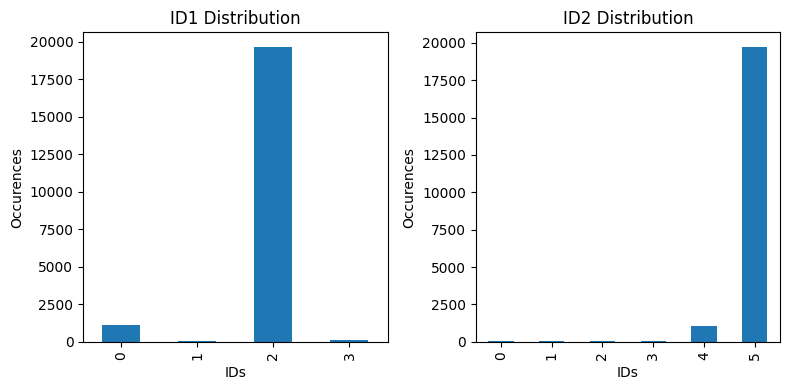

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()

df['id1'].value_counts().sort_index().plot(
    kind='bar', title='ID1 Distribution', xlabel='IDs', ylabel='Occurences', ax=axs[0])
df['id2'].value_counts().sort_index().plot(
    kind='bar', title='ID2 Distribution', xlabel='IDs', ylabel='Occurences', ax=axs[1])

plt.tight_layout()
saveDistPath = os.path.join(imageFolder, saveBase)
saveDistPath += '_unbalancedDistribution.pdf'
plt.savefig(saveDistPath)

In [7]:
if customBalance:
    id1_dict = {}
    id2_dict = {}

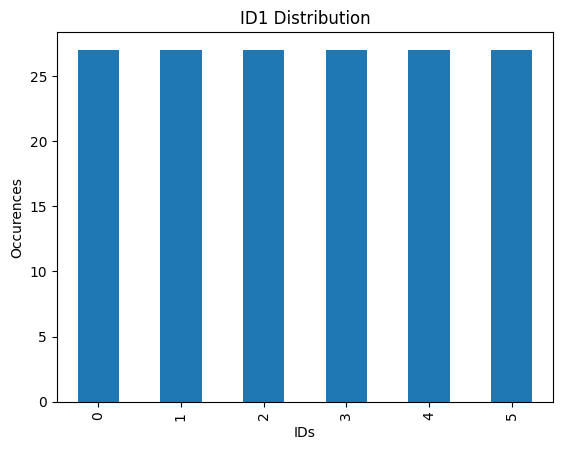

In [8]:
if targetedUndersampling:
    df_x = df.drop(id, axis=1)
    df_x = df_x.drop(ids_remove, axis=1)
    if customBalance:
        X_resampled, y_resampled = RandomUnderSampler(
            sampling_strategy=id2_dict, random_state=SEED).fit_resample(df_x, df[id])
    else:
        X_resampled, y_resampled = RandomUnderSampler(random_state=SEED).fit_resample(df_x, df[id])

    X_resampled[id] = y_resampled
    # for id_remove in ids_remove:
    #     X_resampled[id_remove]
    df = X_resampled

    df[id].value_counts().sort_index().plot(
        kind='bar', title='ID1 Distribution', xlabel='IDs', ylabel='Occurences')
    
    saveBalPath = os.path.join(imageFolder, saveBase)
    saveBalPath += '_balancedDistribution.pdf'
    plt.savefig(saveBalPath)

In [9]:
beforeFeat = df.shape[1]
tsfresh.utilities.dataframe_functions.impute(df)

if filterFeatures:
    df = tsfresh.select_features(df, df[id])
    afterFeat = df.shape[1]

    print(f'[🔥 FILTER]\n\tBefore: {beforeFeat}\n\tAfter: {afterFeat}')


[🔥 FILTER]
	Before: 788
	After: 399


## 💪 Training

In [ ]:
# Loading labels
labels = df[id][:, np.newaxis]

if authentication:
    # Lists of datasets
    X_trains = []
    X_tests = []
    Y_trains = []
    Y_tests = []
    all_balances = []

    for balance in BALANCES:
        # Translating to authentication, i.e., taking only one label
        # Saving different dataset, one for each label
        for label in np.unique(labels):
            labels_auth = []
            for l in labels:
                if l == label:
                    labels_auth.append(1)
                else:
                    labels_auth.append(0)

            labels_auth = np.array(labels_auth)

            l0 = 0
            l1 = 0
            for l in labels_auth:
                if l == 0:
                    l0 += 1
                else:
                    l1 += 1

            # How many 0s would I need by looking at the 1 class
            requested_0 = int(l1 / balance[1] * balance[0])
            # How many 1s would I need by looking at the 0 class
            requested_1 = int(l0 / balance[0] * balance[1])

            if requested_0 < l0:
                num_samples = {
                    0: requested_0,
                    1: l1
                }
            if requested_1 < l1:
                num_samples = {
                    0: l0,
                    1: requested_1
                }

            # Loading features
            features = df.drop(id, axis=1)

            # Dataset balancing
            features, labels_auth = RandomUnderSampler(sampling_strategy=num_samples,
                random_state=SEED).fit_resample(features, labels_auth)

            # Train and test split
            X_train, X_test, Y_train, Y_test = train_test_split(
                features, labels_auth, test_size=0.2, random_state=SEED)

            cols = []
            for col in X_train.columns:
                cols.append(col.replace('z2__', ''))

            X_train.columns = cols
            X_test.columns = cols

            X_trains.append(X_train)
            X_tests.append(X_test)
            Y_trains.append(Y_train)
            Y_tests.append(Y_test)
            all_balances.append(balance)
else:
    # Loading features
    features = df.drop(id, axis=1)
    if not targetedUndersampling:
        for id_remove in ids_remove:
            features = features.drop(id_remove, axis=1)

    # Train and test split
    X_train, X_test, Y_train, Y_test = train_test_split(
        features, labels, test_size=0.2, random_state=SEED)

    cols = []
    for col in X_train.columns:
        cols.append(col.replace('z2__', ''))

    X_train.columns = cols
    X_test.columns = cols

In [ ]:
train_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
best_params = []
model_balances = []

fars = []
frrs = []

complexity = []

# Iterate over classifiers
for name, clf, param in zip(names, classifiers, parameters):
    if authentication:
        score_trains = []
        accuracy_tests = []
        precision_tests = []
        recall_tests = []
        f1_tests = []
        fars_tests = []
        frrs_tests = []
        for i, (X_train, X_test, Y_train, Y_test, balance) in enumerate(zip(X_trains, X_tests, Y_trains, Y_tests, all_balances)):
            # Defining GridSearch
            grid = GridSearchCV(clf, param, n_jobs=-1, verbose=0)
            print(f'[🤖 MODEL] {name} ({i+1}/{len(X_trains)})', end='\r')
            # Fitting the model
            grid.fit(X_train, Y_train)
            # Training score
            score_trains.append(grid.best_estimator_.score(X_train, Y_train))
            # Test scores
            start_pred = time.time()
            Y_pred = grid.best_estimator_.predict(X_test)
            end_pred = time.time()

            pred_time = end_pred - start_pred
            size = sys.getsizeof(pickle.dumps(grid.best_estimator_))

            complexity.append({
                'Model': name,
                'Prediction_Time': pred_time,
                'Size': size
            })
            
            accuracy_tests.append(accuracy_score(Y_test, Y_pred))
            precision_tests.append(precision_score(Y_test, Y_pred))
            recall_tests.append(recall_score(Y_test, Y_pred))
            f1_tests.append(f1_score(Y_test, Y_pred))
            # FARs and FRRs
            cm = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
            tp = cm[0][0]
            tn = cm[1][1]
            fp = cm[0][1]
            fn = cm[1][0]
            far = fp/(fp+tn)
            if math.isnan(far):
                far = 0
            frr = fn/(fn+tp)
            if math.isnan(frr):
                frr = 0
            fars_tests.append(far)
            frrs_tests.append(frr)
            
            # Save results by doing the mean on each balance value
            if (i+1) % len(np.unique(labels)) == 0:
                print()
                print(f'\t[⚖️ BALANCE] {balance[0]}/{balance[1]}')
                print(f'\t\t[💪 TRAIN]\t{round(np.mean(score_trains), 3)}')
                print(f'\t\t[📊 ACCURACY]\t{round(np.mean(accuracy_tests), 3)}')
                print(f'\t\t[📊 PRECISION]\t{round(np.mean(precision_tests), 3)}')
                print(f'\t\t[📊 RECALL]\t{round(np.mean(recall_tests), 3)}')
                print(f'\t\t[📊 F1 SCORE]\t{round(np.mean(f1_tests), 3)}')
                print(f'\t\t[🔐 FAR]\t{round(np.mean(fars_tests), 3)}')
                print(f'\t\t[🔐 FRR]\t{round(np.mean(frrs_tests), 3)}\n')
                # Saving results
                train_scores.append(round(np.mean(score_trains), 3))
                accuracy_scores.append(round(np.mean(accuracy_tests), 3))
                precision_scores.append(round(np.mean(precision_tests), 3))
                recall_scores.append(round(np.mean(recall_tests), 3))
                f1_scores.append(round(np.mean(f1_tests), 3))
                fars.append(round(np.mean(fars_tests), 3))
                frrs.append(round(np.mean(frrs_tests), 3))
                best_params.append(grid.best_params_)
                model_balances.append(balance)
                # Resetting results
                score_trains = []
                accuracy_tests = []
                precision_tests = []
                recall_tests = []
                f1_tests = []
                fars_tests = []
                frrs_tests = []

        print('-' * 50)
        print()
    else:
        print(f'[🤖 MODEL] {name}')
        # Defining GridSearch
        grid = GridSearchCV(clf, param, n_jobs=-1, verbose=0)
        # Fitting the model
        grid.fit(X_train, Y_train)
        # Training score
        score_train = grid.best_estimator_.score(X_train, Y_train)
        print(f'\t[💪 TRAIN]\t{round(score_train, 3)}')
        # Test scores
        # Test scores
        start_pred = time.time()
        Y_pred = grid.best_estimator_.predict(X_test)
        end_pred = time.time()

        pred_time = end_pred - start_pred
        size = sys.getsizeof(pickle.dumps(grid.best_estimator_))

        complexity.append({
            'Model': name,
            'Prediction_Time': pred_time,
            'Size': size
        })
        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred, average='macro')
        recall = recall_score(Y_test, Y_pred, average='macro')
        f1 = f1_score(Y_test, Y_pred, average='macro')

        print(f'\t[📊 ACCURACY]\t{round(accuracy, 3)}')
        print(f'\t[📊 PRECISION]\t{round(precision, 3)}')
        print(f'\t[📊 RECALL]\t{round(recall, 3)}')
        print(f'\t[📊 F1 SCORE]\t{round(f1, 3)}\n')

        train_scores.append(round(score_train, 3))
        accuracy_scores.append(round(accuracy, 3))
        precision_scores.append(round(precision, 3))
        recall_scores.append(round(recall, 3))
        f1_scores.append(round(f1, 3))
        best_params.append(grid.best_params_)

    # Feature importance for Random Forest
    if name == 'Random Forest':
        # Confusion Matrix
        conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
        # Explainable ML
        impurity = grid.best_estimator_.feature_importances_
        std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.estimators_], axis=0)
        explainer = shap.TreeExplainer(grid.best_estimator_)
        shap_values = explainer.shap_values(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Random Forest', fontsize=18)

saveConfPath = os.path.join(imageFolder, saveBase)
saveConfPath += '_confusionMatrix.pdf'
plt.savefig(saveConfPath)

## 🔝 Feature Importance

In [ ]:
forest_impurity = pd.Series(impurity, index=X_train.columns).nlargest(20)

fig, ax = plt.subplots()
forest_impurity.plot.bar(ax=ax)  # , yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# plt.xticks(rotation = 90)
fig.tight_layout()

saveMDIPath = os.path.join(imageFolder, saveBase)
saveMDIPath += '_MDI.pdf'
plt.savefig(saveMDIPath)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
saveShapPath = os.path.join(imageFolder, saveBase)
saveShapPath += '_Shap.pdf'
plt.savefig(saveShapPath)

## 💾 Saving Results

In [ ]:
df_list = []

name_idx = 0
for i, (acc, prec, rec, f1) in enumerate(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)):
    df_list.append({
        'Model': names[name_idx],
        'ID': id[-1],
        'Authentication': authentication,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })
    if authentication:
        if (i+1) % len(BALANCES) == 0:
            name_idx += 1
    else:
        name_idx += 1

if authentication:
    for i, (far, frr, dfl) in enumerate(zip(fars, frrs, df_list)):
        dfl['FAR'] = far
        dfl['FRR'] = frr
        dfl['Balance'] = str(model_balances[i][0]) + '/' + str(model_balances[i][1])

df_csv = pd.DataFrame(df_list)
savePath = os.path.join(RESULTS, saveBase)
savePath += '.csv'
df_csv.to_csv(savePath)

# Saving times and sizes
df_comp = pd.DataFrame(complexity)
timeSavePath = os.path.join(COMPLEXITY, saveBase)
timeSavePath += '.csv'
df_comp.to_csv(timeSavePath)